In [1]:
# Import libraries

import math
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from botorch.models import SingleTaskGP, FixedNoiseGP, ModelListGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood, SumMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement, qExpectedImprovement, qNoisyExpectedImprovement
from botorch.acquisition.analytic import ProbabilityOfImprovement
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.constraints import GreaterThan, Interval
from botorch.sampling import IIDNormalSampler
from botorch.optim import optimize_acqf
from sklearn.preprocessing import StandardScaler
from HIL.optimization.kernel import SE, Matern 
from botorch.models.converter import batched_to_model_list, model_list_to_batched

## Single objective optimization

In [4]:
### CHANGE ###

os.chdir(r'C:\Users\sruth\OneDrive - University of Illinois at Chicago\Documents\GitHub\HIL_toolkit_ARL\models\test')
# Import the x and y data
df_xy = pd.read_csv("Feb_29_ETC.csv", delim_whitespace=True, header=None)

# Extract the first column as x and convert to a 1D Numpy array
x = df_xy.iloc[:, 0].values

# Extract the second column as y and convert to a 2D Numpy array
y = df_xy.iloc[:, 1].values

# Convert x and y numpy arrays to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
x_tensor = x_tensor.view(x_tensor.shape[0], 1)
y_tensor = torch.tensor(y, dtype=torch.float32)
print("Shape of x tensor", x_tensor.shape)
print("Shape of y tensor", y_tensor.shape)


### CHANGE ###
# Set the range of the parameter space
x_range = np.array([90, 130])                      

Shape of x tensor torch.Size([12, 1])
Shape of y tensor torch.Size([12])


In [33]:
# Define kernel and Likelihood (kernel contains the hyperparameters length scale and output scale variance, while the likelihood contains the hyperparameter noise variance)
kernel = SE(1) # argument n_parms = 1
covar_module = kernel.get_covr_module()   # open HIL.optimization.kernel.py and set the limits of the lengthscale variance and output scale variance.
noise_range = np.array([0.0, 3.0])  # Set the limits for the noise range
likelihood = GaussianLikelihood(noise_constraint = Interval(noise_range[0], noise_range[1]))

# # The kernel specifies the covariance (or similarity) between different points in the input space. 
# # It determines how the output values at different input points are correlated.
# # In other words, the kernel captures the smoothness and correlations in the underlying function 

# # The likelihood models the noise or uncertainty in the observed data. 
# # It represents the probability distribution of the observed output given the true underlying function values 
# # predicted by the GP.

In [44]:
# Tune the hyperparameters and fit the GP model

# Train the model and tune the hyperparameters using Adam optimizer)
def _training_single_objective_Adam(train_x, train_y, likelihood, covar_module):
    """
    Train the single-objective model using Adam Optimizer and gradient descent.
    Log Marginal Likelihood is used as the cost function.
    """

    # Initialize the single objective Gaussian Process model with the likelihood and kernel
    single_objective_model = SingleTaskGP(train_x, train_y.unsqueeze(-1), likelihood = likelihood, covar_module = covar_module)

    # Set up the Adam optimizer
    parameters = list(single_objective_model.parameters()) + list(likelihood.parameters())
    optimizer = torch.optim.Adam(parameters, lr=0.01)
    
    # Training loop
    for epoch in range(1000):
        
        optimizer.zero_grad()

        # Forward pass to get the output from the model
        # During the forward pass, operations are performed on tensors, and a computation graph is built to represent the sequence of operations.

        # Loss Calculation: At the end of the forward pass, a scalar tensor is usually obtained, representing the loss or objective function. 
        # This scalar tensor is what you want to minimize during training.

        output = single_objective_model(train_x)
            
        # Calculate Exact Marginal Log Likelihood (loss function) for the current model
        mll = ExactMarginalLogLikelihood(single_objective_model.likelihood, single_objective_model)
        loss = -mll(output, train_y) 

        # Backward pass 
        # The backward() method is called on the scalar tensor. It computes the gradients of the loss function with 
        # respect to each parameter of the model. 
        loss.backward()
        
        # Optimization step (Parameter update)
        # Adjusts the model parameters in the opposite direction of the gradients to minimize the loss.
        optimizer.step()
        
        # Print the loss after every 50 epochs
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
        
        
    # Extract optimized hyperparameters
  
    # Hyperparameters of the covariance module (kernel)
    output_scale = single_objective_model.covar_module.outputscale.item()
    length_scale = single_objective_model.covar_module.base_kernel.lengthscale.item()

    # Hyperparameters of the likelihood
    noise_variance = single_objective_model.likelihood.noise_covar.noise.item()

    return single_objective_model, output_scale, length_scale, noise_variance


# Train the GP models and tune the hyperparameters using fit_gpytorch_model

# # fit_gpytorch_model(mll) is a method provided by BoTorch (a library built on top of PyTorch) that 
# # performs hyperparameter optimization for Gaussian Process (GP) models. It is an alternative way to optimize the hyperparameters 
# # of the GP model compared to using a separate optimizer.

def _training_single_objective_gpytorch(train_x, train_y, likelihood, covar_module): 
    """
    Train the single-objective model using fit_gpytorch_model.
    Log Marginal Likelihood is used as the cost function.
    """
    
    # Initialize the single objective Gaussian Process model with the likelihood and kernel
    single_objective_model = SingleTaskGP(train_x, train_y.unsqueeze(-1), likelihood = likelihood, covar_module = covar_module)

    
    loss = ExactMarginalLogLikelihood(single_objective_model.likelihood, single_objective_model)

    # Fit the model (optimize hyperparameters)
    fit_gpytorch_model(loss)

    # Extract optimized hyperparameters
  
    # Hyperparameters of the covariance module (kernel)
    output_scale = single_objective_model.covar_module.outputscale.item()
    length_scale = single_objective_model.covar_module.base_kernel.lengthscale.item()

    # Hyperparameters of the likelihood
    noise_variance = single_objective_model.likelihood.noise_covar.noise.item()

    return single_objective_model, output_scale, length_scale, noise_variance

In [45]:
# Call the _training_single_objective_Adam method, which optimizes the hyperparameters and fits the model, returns the trained model list and optimized hyperparameters
# trained_model, os, ls, nv = _training_single_objective_Adam(x_tensor, y_tensor, likelihood, covar_module)  

# Call the _training_multi_objective_gpytorch method, which optimizes the hyperparameters and fits the model, returns the trained model list and optimized hyperparameters
trained_model, os, ls, nv = _training_single_objective_gpytorch(x_tensor, y_tensor, likelihood, covar_module)


C:\Users\sruth\AppData\Local\Programs\Python\Python310\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
C:\Users\sruth\AppData\Local\Programs\Python\Python310\lib\site-packages\botorch\models\utils\assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\sruth\AppData\Local\Programs\Python\Python310\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([58.6667]), std = tensor([4.0527])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(m

In [46]:
# Generate test points in the range of the parameter space, for plotting
test_x = torch.linspace(x_range[0], x_range[1], 100).unsqueeze(-1)

# Make predictions for the test points - Obtain the posterior predictive distribution for the test points
trained_model.eval()
scaling_factor = 1.96 # Z-value associated with 95% is z = 1.96 # Z-value associated witb 99% is 2.57
observed = []
observed_mean = []
std_dev = []
lower = []
upper = []

with torch.no_grad():
    # Get the posterior distribution for model
    observed = trained_model.likelihood(trained_model(test_x))
        
    # Extract mean and variance
    observed_mean = observed.mean.cpu().numpy()
        
    # print(observed_mean)
    std_dev = observed.stddev.cpu().numpy()
        
    # Obtain the confidence intervals
    upper = observed_mean + scaling_factor * std_dev
    lower = observed_mean - scaling_factor * std_dev

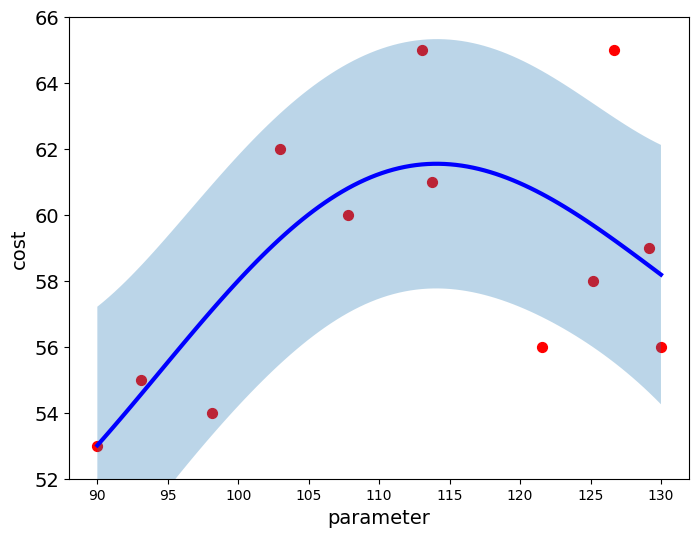

In [47]:
# Plot the trained Gaussian Process model

plt.figure(figsize=(8, 6))
plt.plot(test_x, observed_mean, label='mean', linewidth=3, color='b')
plt.scatter(x, y, label='Points', color='r', marker='o', s=50)
plt.fill_between(test_x.squeeze(), lower.squeeze(), upper.squeeze(), alpha=0.3)
plt.yticks(fontsize=14)
plt.ylim(y.min()-1, y.max()+1)
plt.xlabel('parameter', fontsize=14)
plt.ylabel('cost', fontsize=14)
#plt.axvline(x = 0.5789, color = 'r', label = 'optimal')
plt.show()

In [ ]:
# Hyperparameter time series

## Multi-objective optimization

In [129]:
# Import data

### CHANGE ###
#os.chdir(r'C:\Users\sruth\OneDrive - University of Illinois at Chicago\Documents\GitHub\HIL_toolkit_ARL\models\test')
# Import the x and y data
df_xy = pd.read_csv("Feb_29_full_data.csv", delim_whitespace=True, header=None, skiprows=[0])

# Extract the first column as x and convert to a 1D Numpy array
x = df_xy.iloc[:, 0].values

# Extract the second and third columns as a vector of two objectives (y1 and y2), and convert to a 2D Numpy array
y = df_xy.iloc[:, 1:].values

# Convert x and y numpy arrays to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
x_tensor = x_tensor.view(x_tensor.shape[0], 1)
y_tensor = torch.tensor(y, dtype=torch.float32)
print("Shape of x tensor", x_tensor.shape)
print("Shape of y tensor", y_tensor.shape)

### CHANGE ###
# Set the range of the parameter space
x_range = np.array([90, 130])    

Shape of x tensor torch.Size([12, 1])
Shape of y tensor torch.Size([12, 2])


In [147]:
# Define kernel and Likelihood (kernel contains the hyperparameters length scale and output scale variance, while the likelihood contains the hyperparameter noise variance)
kernel = SE(1) # argument n_parms = 1
covar_module = kernel.get_covr_module()   # open HIL.optimization.kernel.py and set the limits of the lengthscale variance and output scale variance.

noise_range_1 = np.array([0.0, 1.0])  # Set the limits for the noise range for objective 1
noise_range_2 = np.array([0.0, 2.0])  # Set the limits for the noise range for objective 2

likelihood_1 = GaussianLikelihood(noise_constraint = Interval(noise_range_1[0], noise_range_1[1]))
likelihood_2 = GaussianLikelihood(noise_constraint = Interval(noise_range_2[0], noise_range_2[1]))

# Store the likelihoods as a list
likelihood = []
likelihood.append(likelihood_1)
likelihood.append(likelihood_2)

In [148]:
# Train the models and tune the hyperparameters using Adam optimizer
def _training_multi_objective_Adam(train_x, train_y, likelihood, covar_module):
    """
    Train the multi-objective model using Adam Optimizer and gradient descent.
    Log Marginal Likelihood is used as the cost function.
    """
    num_objectives = train_y.shape[-1]

    # Initialize a list to store individual GP models for each objective
    models = []
    for i in range(num_objectives):
        # Create a SingleTaskGP for each objective
        single_objective_model = SingleTaskGP(train_x, train_y[:, i].unsqueeze(-1), likelihood = likelihood[i], covar_module = covar_module) 
        models.append(single_objective_model)

    # Create a ModelListGP to manage multiple objectives
    model_list = ModelListGP(*models)
    
    # Set up the optimizer
    parameters = list(model_list.parameters()) #+ list(likelihood[0].parameters()) + list(likelihood[1].parameters())
    optimizer = torch.optim.Adam(parameters, lr=0.01)
    
    # Training loop
    for epoch in range(1000):
        
        optimizer.zero_grad()
        
        # Loop over individual models in the ModelListGP
        for i, model in enumerate(model_list.models):
            # Forward pass to get the output from the model
            # During the forward pass, operations are performed on tensors, and a computation graph is built to represent the sequence of operations.

            # Loss Calculation: At the end of the forward pass, a scalar tensor is usually obtained, representing the loss or objective function. 
            # This scalar tensor is what you want to minimize during training.

            output = model(train_x)
            
            # Calculate Exact Marginal Log Likelihood (loss function) for the current model
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            loss = -mll(output, train_y[:, i]) 
            
            # Backward pass 
            # The backward() method is called on the scalar tensor. It computes the gradients of the loss function with 
            # respect to each parameter of the model. 
            loss.backward()
        
            # Optimization step (Parameter update)
            # Adjusts the model parameters in the opposite direction of the gradients to minimize the loss.
            optimizer.step()
        
            # Print the loss after every 50 epochs
            if epoch % 50 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item()}")
    
    # Extract optimized hyperparameters
  
    # Objective 1
    # Hyperparameters of the covariance module (kernel)
    output_scale_1 = model_list.models[0].covar_module.outputscale.item()
    length_scale_1 = model_list.models[0].covar_module.base_kernel.lengthscale.item()

    # Hyperparameters of the likelihood
    noise_variance_1 = model_list.models[0].likelihood.noise_covar.noise.item()

    # Objective 2
    # Hyperparameters of the covariance module (kernel)
    output_scale_2 = model_list.models[1].covar_module.outputscale.item()
    length_scale_2 = model_list.models[1].covar_module.base_kernel.lengthscale.item()

    # Hyperparameters of the likelihood
    noise_variance_2 = model_list.models[1].likelihood.noise_covar.noise.item()

    return model_list, output_scale_1, length_scale_1, noise_variance_1, output_scale_2, length_scale_2, noise_variance_2



# Train the models and tune the hyperparameters using Adam optimizer
def _training_multi_objective_Adam(train_x, train_y, likelihood, covar_module):
    """
    Train the multi-objective model using Adam Optimizer and gradient descent.
    Log Marginal Likelihood is used as the cost function.
    """
    num_objectives = train_y.shape[-1]

    # Initialize a list to store individual GP models for each objective
    models = []
    for i in range(num_objectives):
        # Create a SingleTaskGP for each objective
        single_objective_model = SingleTaskGP(train_x, train_y[:, i].unsqueeze(-1), likelihood = likelihood[i], covar_module = covar_module) 
        models.append(single_objective_model)

    # Create a ModelListGP to manage multiple objectives
    model_list = ModelListGP(*models)
    
    # Set up the optimizer
    parameters = list(model_list.parameters()) #+ list(likelihood[0].parameters()) + list(likelihood[1].parameters())
    optimizer = torch.optim.Adam(parameters, lr=0.01)
    
    # Training loop
    for epoch in range(1000):
        
        optimizer.zero_grad()
        
        # Loop over individual models in the ModelListGP
        for i, model in enumerate(model_list.models):
            # Forward pass to get the output from the model
            # During the forward pass, operations are performed on tensors, and a computation graph is built to represent the sequence of operations.

            # Loss Calculation: At the end of the forward pass, a scalar tensor is usually obtained, representing the loss or objective function. 
            # This scalar tensor is what you want to minimize during training.

            output = model(train_x)
            
            # Calculate Exact Marginal Log Likelihood (loss function) for the current model
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            loss = -mll(output, train_y[:, i]) 
            
            # Backward pass 
            # The backward() method is called on the scalar tensor. It computes the gradients of the loss function with 
            # respect to each parameter of the model. 
            loss.backward()
        
            # Optimization step (Parameter update)
            # Adjusts the model parameters in the opposite direction of the gradients to minimize the loss.
            optimizer.step()
        
            # Print the loss after every 50 epochs
            if epoch % 50 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item()}")
    
    # Extract optimized hyperparameters
  
    # Objective 1
    # Hyperparameters of the covariance module (kernel)
    output_scale_1 = model_list.models[0].covar_module.outputscale.item()
    length_scale_1 = model_list.models[0].covar_module.base_kernel.lengthscale.item()

    # Hyperparameters of the likelihood
    noise_variance_1 = model_list.models[0].likelihood.noise_covar.noise.item()

    # Objective 2
    # Hyperparameters of the covariance module (kernel)
    output_scale_2 = model_list.models[1].covar_module.outputscale.item()
    length_scale_2 = model_list.models[1].covar_module.base_kernel.lengthscale.item()

    # Hyperparameters of the likelihood
    noise_variance_2 = model_list.models[1].likelihood.noise_covar.noise.item()

    return model_list, output_scale_1, length_scale_1, noise_variance_1, output_scale_2, length_scale_2, noise_variance_2



# Train the models and tune the hyperparameters using Adam optimizer
def _training_multi_objective_Adam(train_x, train_y, likelihood, covar_module):
    """
    Train the multi-objective model using Adam Optimizer and gradient descent.
    Log Marginal Likelihood is used as the cost function.
    """
    num_objectives = train_y.shape[-1]

    # Initialize a list to store individual GP models for each objective
    models = []
    for i in range(num_objectives):
        # Create a SingleTaskGP for each objective
        single_objective_model = SingleTaskGP(train_x, train_y[:, i].unsqueeze(-1), likelihood = likelihood[i], covar_module = covar_module) 
        models.append(single_objective_model)

    # Create a ModelListGP to manage multiple objectives
    model_list = ModelListGP(*models)
    
    # Set up the optimizer
    parameters = list(model_list.parameters()) #+ list(likelihood[0].parameters()) + list(likelihood[1].parameters())
    optimizer = torch.optim.Adam(parameters, lr=0.01)
    
    # Training loop
    for epoch in range(1000):
        
        optimizer.zero_grad()
        
        # Loop over individual models in the ModelListGP
        for i, model in enumerate(model_list.models):
            # Forward pass to get the output from the model
            # During the forward pass, operations are performed on tensors, and a computation graph is built to represent the sequence of operations.

            # Loss Calculation: At the end of the forward pass, a scalar tensor is usually obtained, representing the loss or objective function. 
            # This scalar tensor is what you want to minimize during training.

            output = model(train_x)
            
            # Calculate Exact Marginal Log Likelihood (loss function) for the current model
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            loss = -mll(output, train_y[:, i]) 
            
            # Backward pass 
            # The backward() method is called on the scalar tensor. It computes the gradients of the loss function with 
            # respect to each parameter of the model. 
            loss.backward()
        
            # Optimization step (Parameter update)
            # Adjusts the model parameters in the opposite direction of the gradients to minimize the loss.
            optimizer.step()
        
            # Print the loss after every 50 epochs
            if epoch % 50 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item()}")
    
    # Extract optimized hyperparameters
  
    # Objective 1
    # Hyperparameters of the covariance module (kernel)
    output_scale_1 = model_list.models[0].covar_module.outputscale.item()
    length_scale_1 = model_list.models[0].covar_module.base_kernel.lengthscale.item()

    # Hyperparameters of the likelihood
    noise_variance_1 = model_list.models[0].likelihood.noise_covar.noise.item()

    # Objective 2
    # Hyperparameters of the covariance module (kernel)
    output_scale_2 = model_list.models[1].covar_module.outputscale.item()
    length_scale_2 = model_list.models[1].covar_module.base_kernel.lengthscale.item()

    # Hyperparameters of the likelihood
    noise_variance_2 = model_list.models[1].likelihood.noise_covar.noise.item()

    return model_list, output_scale_1, length_scale_1, noise_variance_1, output_scale_2, length_scale_2, noise_variance_2









In [149]:
# # Call the _training_multi_objective_Adam method, which optimizes the hyperparameters and fits the model, returns the trained model list and optimized hyperparameters
trained_model_list, os_1, ls_1, nv_1, os_2, ls_2, nv_2 = _training_multi_objective_Adam(x_tensor, y_tensor, likelihood, covar_module)
# trained_model_list, os_1, ls_1, nv_1, os_2, ls_2, nv_2 = _training_multi_objective(x_tensor, y_tensor)


# Call the _training_multi_objective_gpytorch method, which optimizes the hyperparameters and fits the model, returns the trained model list and optimized hyperparameters
# trained_model_list, os_1, ls_1, nv_1, os_2, ls_2, nv_2 = _training_multi_objective_gpytorch(x_tensor, y_tensor, likelihood, covar_module)


Epoch 0, Loss: 12.195049285888672
Epoch 0, Loss: 186.73736572265625
Epoch 50, Loss: 9.650104522705078
Epoch 50, Loss: 135.3224334716797
Epoch 100, Loss: 8.76488971710205
Epoch 100, Loss: 117.13623046875
Epoch 150, Loss: 8.212437629699707
Epoch 150, Loss: 108.36215209960938
Epoch 200, Loss: 7.884580612182617
Epoch 200, Loss: 103.0278549194336
Epoch 250, Loss: 7.662477493286133
Epoch 250, Loss: 99.47200775146484
Epoch 300, Loss: 7.497735500335693
Epoch 300, Loss: 96.94113159179688
Epoch 350, Loss: 7.367149829864502
Epoch 350, Loss: 95.04784393310547
Epoch 400, Loss: 7.258485317230225
Epoch 400, Loss: 93.57403564453125
Epoch 450, Loss: 7.164745807647705
Epoch 450, Loss: 92.38866424560547
Epoch 500, Loss: 7.081645488739014
Epoch 500, Loss: 91.40878295898438
Epoch 550, Loss: 7.0064377784729
Epoch 550, Loss: 90.57943725585938
Epoch 600, Loss: 6.93730354309082
Epoch 600, Loss: 89.8631820678711
Epoch 650, Loss: 6.87297248840332
Epoch 650, Loss: 89.23369598388672
Epoch 700, Loss: 6.812637805938

In [150]:
# Generate test points in the range of the parameter space, for plotting
test_x = torch.linspace(x_range[0], x_range[1], 100).unsqueeze(-1)

# Make predictions for the test points
# Iterate over models and get the posterior predictive distribution for the test points

trained_model_list.eval()
scaling_factor = 1.96 # Z-value associated with 95% is z = 1.96 # Z-value associated witb 99% is 2.57
observed = []
observed_mean = []
std_dev = []
lower = []
upper = []

with torch.no_grad():
    # Loop through each model in the list
    for i, model in enumerate(trained_model_list.models):
        # Get the posterior distribution for the i-th model
        observed_i = model.likelihood(model(test_x))
        
        # Extract mean and variance
        observed_mean_i = observed_i.mean.cpu().numpy()
        
        # print(observed_mean_i)
        std_dev_i = observed_i.stddev.cpu().numpy()
        
        # Obtain the confidence intervals
        upper_i = observed_mean_i + scaling_factor * std_dev_i
        lower_i = observed_mean_i - scaling_factor * std_dev_i

        observed.append(observed_i)
        observed_mean.append(observed_mean_i)
        std_dev.append(std_dev_i)
        lower.append(lower_i)
        upper.append(upper_i)

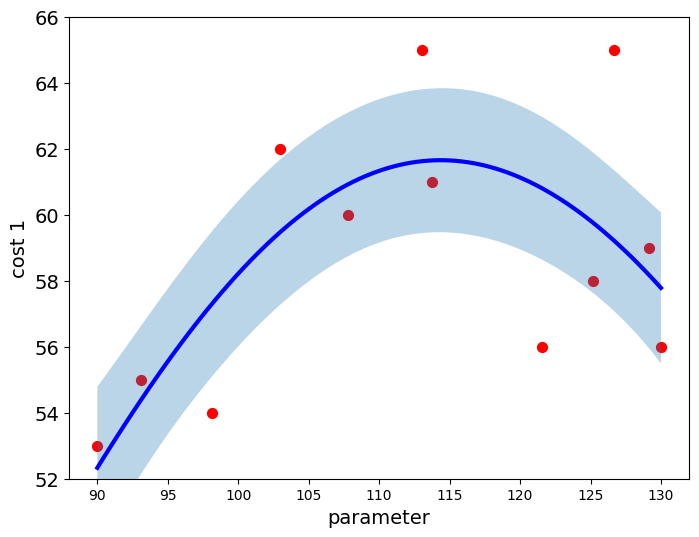

In [151]:
# Plot the GP for the first objective
plt.figure(figsize=(8, 6))
plt.plot(test_x, observed_mean[0], label='mean', linewidth=3, color='b')
plt.scatter(x, y[:,0], label='Points', color='r', marker='o', s=50)
plt.fill_between(test_x.squeeze(), lower[0].squeeze(), upper[0].squeeze(), alpha=0.3)
plt.yticks(fontsize=14)
plt.ylim(y[:,0].min()-1, y[:,0].max()+1)
plt.xlabel('parameter', fontsize=14)
plt.ylabel('cost 1', fontsize=14)
# plt.axvline(x = 0.5789, color = 'r', label = 'axvline - full height')
plt.show()

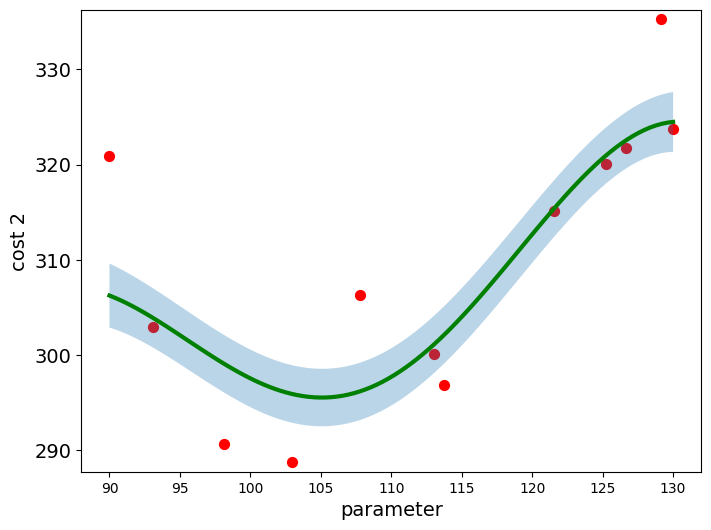

In [152]:
# Plot the GP for the second objective 
plt.figure(figsize=(8, 6))
plt.plot(test_x, observed_mean[1], label='mean', linewidth=3, color='g')
plt.scatter(x, y[:,1], label='Points', color='r', marker='o', s=50)
plt.fill_between(test_x.squeeze(), lower[1].squeeze(), upper[1].squeeze(), alpha=0.3)
plt.yticks(fontsize=14)
plt.ylim(y[:,1].min()-1, y[:,1].max()+1)
plt.xlabel('parameter', fontsize=14)
plt.ylabel('cost 2', fontsize=14)
# plt.axvline(x = 0.5789, color = 'r', label = 'axvline - full height')
plt.show()